In [18]:
from joblib import load
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np

In [2]:
# Load the data
df = pd.read_csv('../data/US_Accidents_March23_cleaned.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127862 entries, 0 to 127861
Data columns (total 46 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Severity               127862 non-null  int64  
 1   Start_Lat              127862 non-null  float64
 2   Start_Lng              127862 non-null  float64
 3   Street                 127862 non-null  object 
 4   City                   127862 non-null  object 
 5   County                 127862 non-null  object 
 6   State                  127862 non-null  object 
 7   Zipcode                127862 non-null  object 
 8   Timezone               127862 non-null  object 
 9   Airport_Code           127862 non-null  object 
 10  Temperature(F)         127862 non-null  float64
 11  Humidity(%)            127862 non-null  float64
 12  Pressure(in)           127862 non-null  float64
 13  Visibility(mi)         127862 non-null  float64
 14  Wind_Direction         127862 non-nu

In [23]:
class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.tree) for x in X])

    def _build_tree(self, X, y, depth=0):
        num_labels = len(np.unique(y))

        # Base cases
        if depth == self.max_depth or num_labels == 1:
            return np.argmax(np.bincount(y))

        best_feature, best_threshold = self._find_best_split(X, y)

        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold

        left_tree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_tree = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return {'feature': best_feature, 'threshold': best_threshold,
                'left': left_tree, 'right': right_tree}

    def _find_best_split(self, X, y):
        best_gain = 0
        best_feature = None
        best_threshold = None

        _, num_features = X.shape

        for feature in range(num_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                gain = self._calculate_gain(X, y, feature, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gain(self, X, y, feature, threshold):
        parent_entropy = self._calculate_entropy(y)

        left_indices = X[:, feature] <= threshold
        right_indices = X[:, feature] > threshold

        left_entropy = self._calculate_entropy(y[left_indices])
        right_entropy = self._calculate_entropy(y[right_indices])

        num_left = len(y[left_indices])
        num_right = len(y[right_indices])
        total_samples = num_left + num_right

        gain = parent_entropy - ((num_left / total_samples) * left_entropy) - ((num_right / total_samples) * right_entropy)

        return gain

    def _calculate_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))

        return entropy

    def _traverse_tree(self, x, tree):
        if isinstance(tree, dict):
            feature = tree['feature']
            threshold = tree['threshold']

            if x[feature] <= threshold:
                return self._traverse_tree(x, tree['left'])
            else:
                return self._traverse_tree(x, tree['right'])
        else:
            return tree

In [16]:
# Load the models
rf_model = load('../models/random_forest_model.pkl')
dt_model = load('../models/decision_tree_model.pkl')

In [6]:
df = df.drop(['Zipcode', 'Airport_Code','Street'], axis=1)
df_dummy = pd.get_dummies(df, drop_first=True)

target='Severity'

y = df_dummy[target]
X = df_dummy.drop(target, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((102289, 8126), (102289,)), ((25573, 8126), (25573,)))

In [22]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

IndexError: string index out of range

In [9]:
print("Classification Report for Random Forest Model")
print(classification_report(y_test_rf, y_pred_rf))


Classification Report for Random Forest Model
              precision    recall  f1-score   support

           1       0.67      0.02      0.03       234
           2       0.82      0.98      0.89     20326
           3       0.65      0.22      0.33      4341
           4       0.38      0.01      0.02       672

    accuracy                           0.81     25573
   macro avg       0.63      0.31      0.32     25573
weighted avg       0.78      0.81      0.77     25573



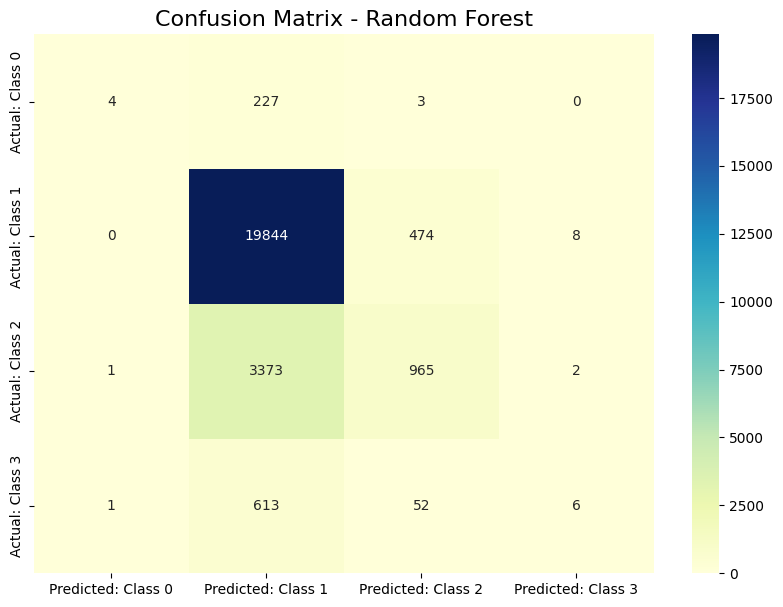

In [13]:
confmat = confusion_matrix(y_true=y_test_rf, y_pred=y_pred_rf)

# Adjusting the labels for a 4-class model
conf_matrix = pd.DataFrame(data=confmat,
                           columns=['Predicted: Class 0', 'Predicted: Class 1', 'Predicted: Class 2', 'Predicted: Class 3'],
                           index=['Actual: Class 0', 'Actual: Class 1', 'Actual: Class 2', 'Actual: Class 3'])

plt.figure(figsize = (10, 7))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu")
plt.title("Confusion Matrix - Random Forest", fontsize=16)  # Adding title
plt.show()